## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# # (re-)load layers
# %run modules.ipynb
import torch
import numpy as np
import unittest
from modules import (
    Module, Sequential, Linear, SoftMax, LogSoftMax, BatchNormalization, ChannelwiseScaling,
    Dropout, ReLU, LeakyReLU, ELU, SoftPlus, ClassNLLCriterion, ClassNLLCriterionUnstable,
    Conv2d, MaxPool2d, Flatten, Criterion, sgd_momentum, adam_optimizer
)

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

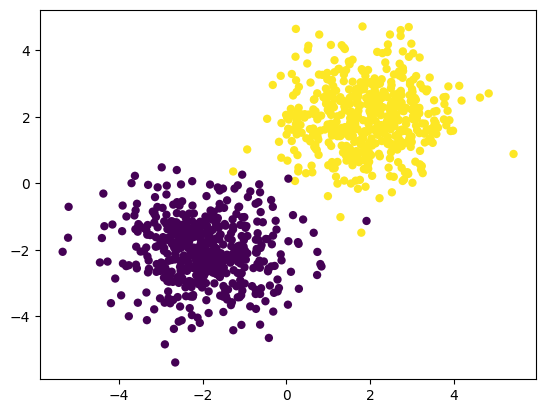

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()



# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

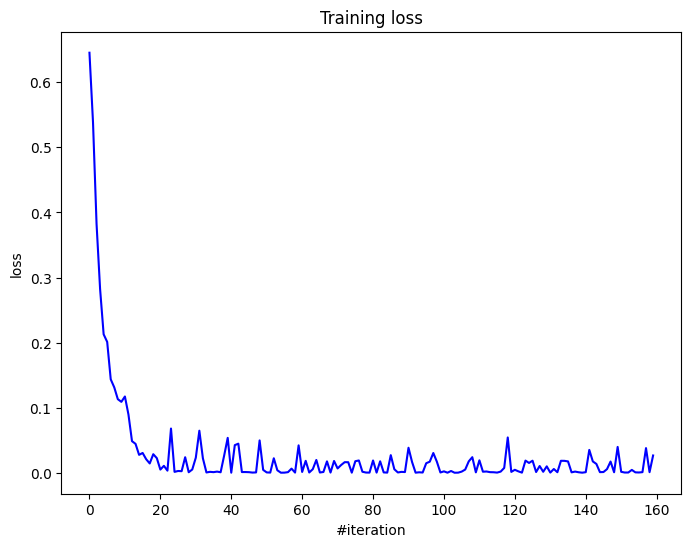

Current loss: 0.026641


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [10]:
import gzip
import os
import numpy as np

In [11]:
def load_mnist_images(filename):
    if not os.path.exists(filename):
        raise FileNotFoundError(f"{filename} not found.")
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, 1, 28, 28)
    return (data / np.float32(256)).squeeze()

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        raise FileNotFoundError(f"{filename} not found.")
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

X_train = load_mnist_images(r'C:\Users\ekart\YS_last_hw\mnist\train-images-idx3-ubyte.gz')
y_train = load_mnist_labels(r'C:\Users\ekart\YS_last_hw\mnist\train-labels-idx1-ubyte.gz')
X_test = load_mnist_images(r'C:\Users\ekart\YS_last_hw\mnist\t10k-images-idx3-ubyte.gz')
y_test = load_mnist_labels(r'C:\Users\ekart\YS_last_hw\mnist\t10k-labels-idx1-ubyte.gz')

X_train, X_val = X_train[:-10000], X_train[-10000:]
y_train, y_val = y_train[:-10000], y_train[-10000:]

flatten = True  

if flatten:
    X_train = X_train.reshape([-1, 28**2])
    X_val = X_val.reshape([-1, 28**2])
    X_test = X_test.reshape([-1, 28**2])


One-hot encode the labels first.

In [12]:
def one_hot(labels):
    return np.eye(10)[labels.reshape(-1)]

one_hot_y_train = one_hot(y_train)
one_hot_y_val = one_hot(y_val)
one_hot_y_test = one_hot(y_test)

X_train = X_train.reshape([len(X_train),-1])
X_val = X_val.reshape([len(X_val),-1])
X_test = X_test.reshape([len(X_test),-1])

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [13]:
def accuracy(prediction, label):
    pred = np.argmax(prediction, axis = -1)
    return 1 - len(np.nonzero(label-pred)[0])/len(label)

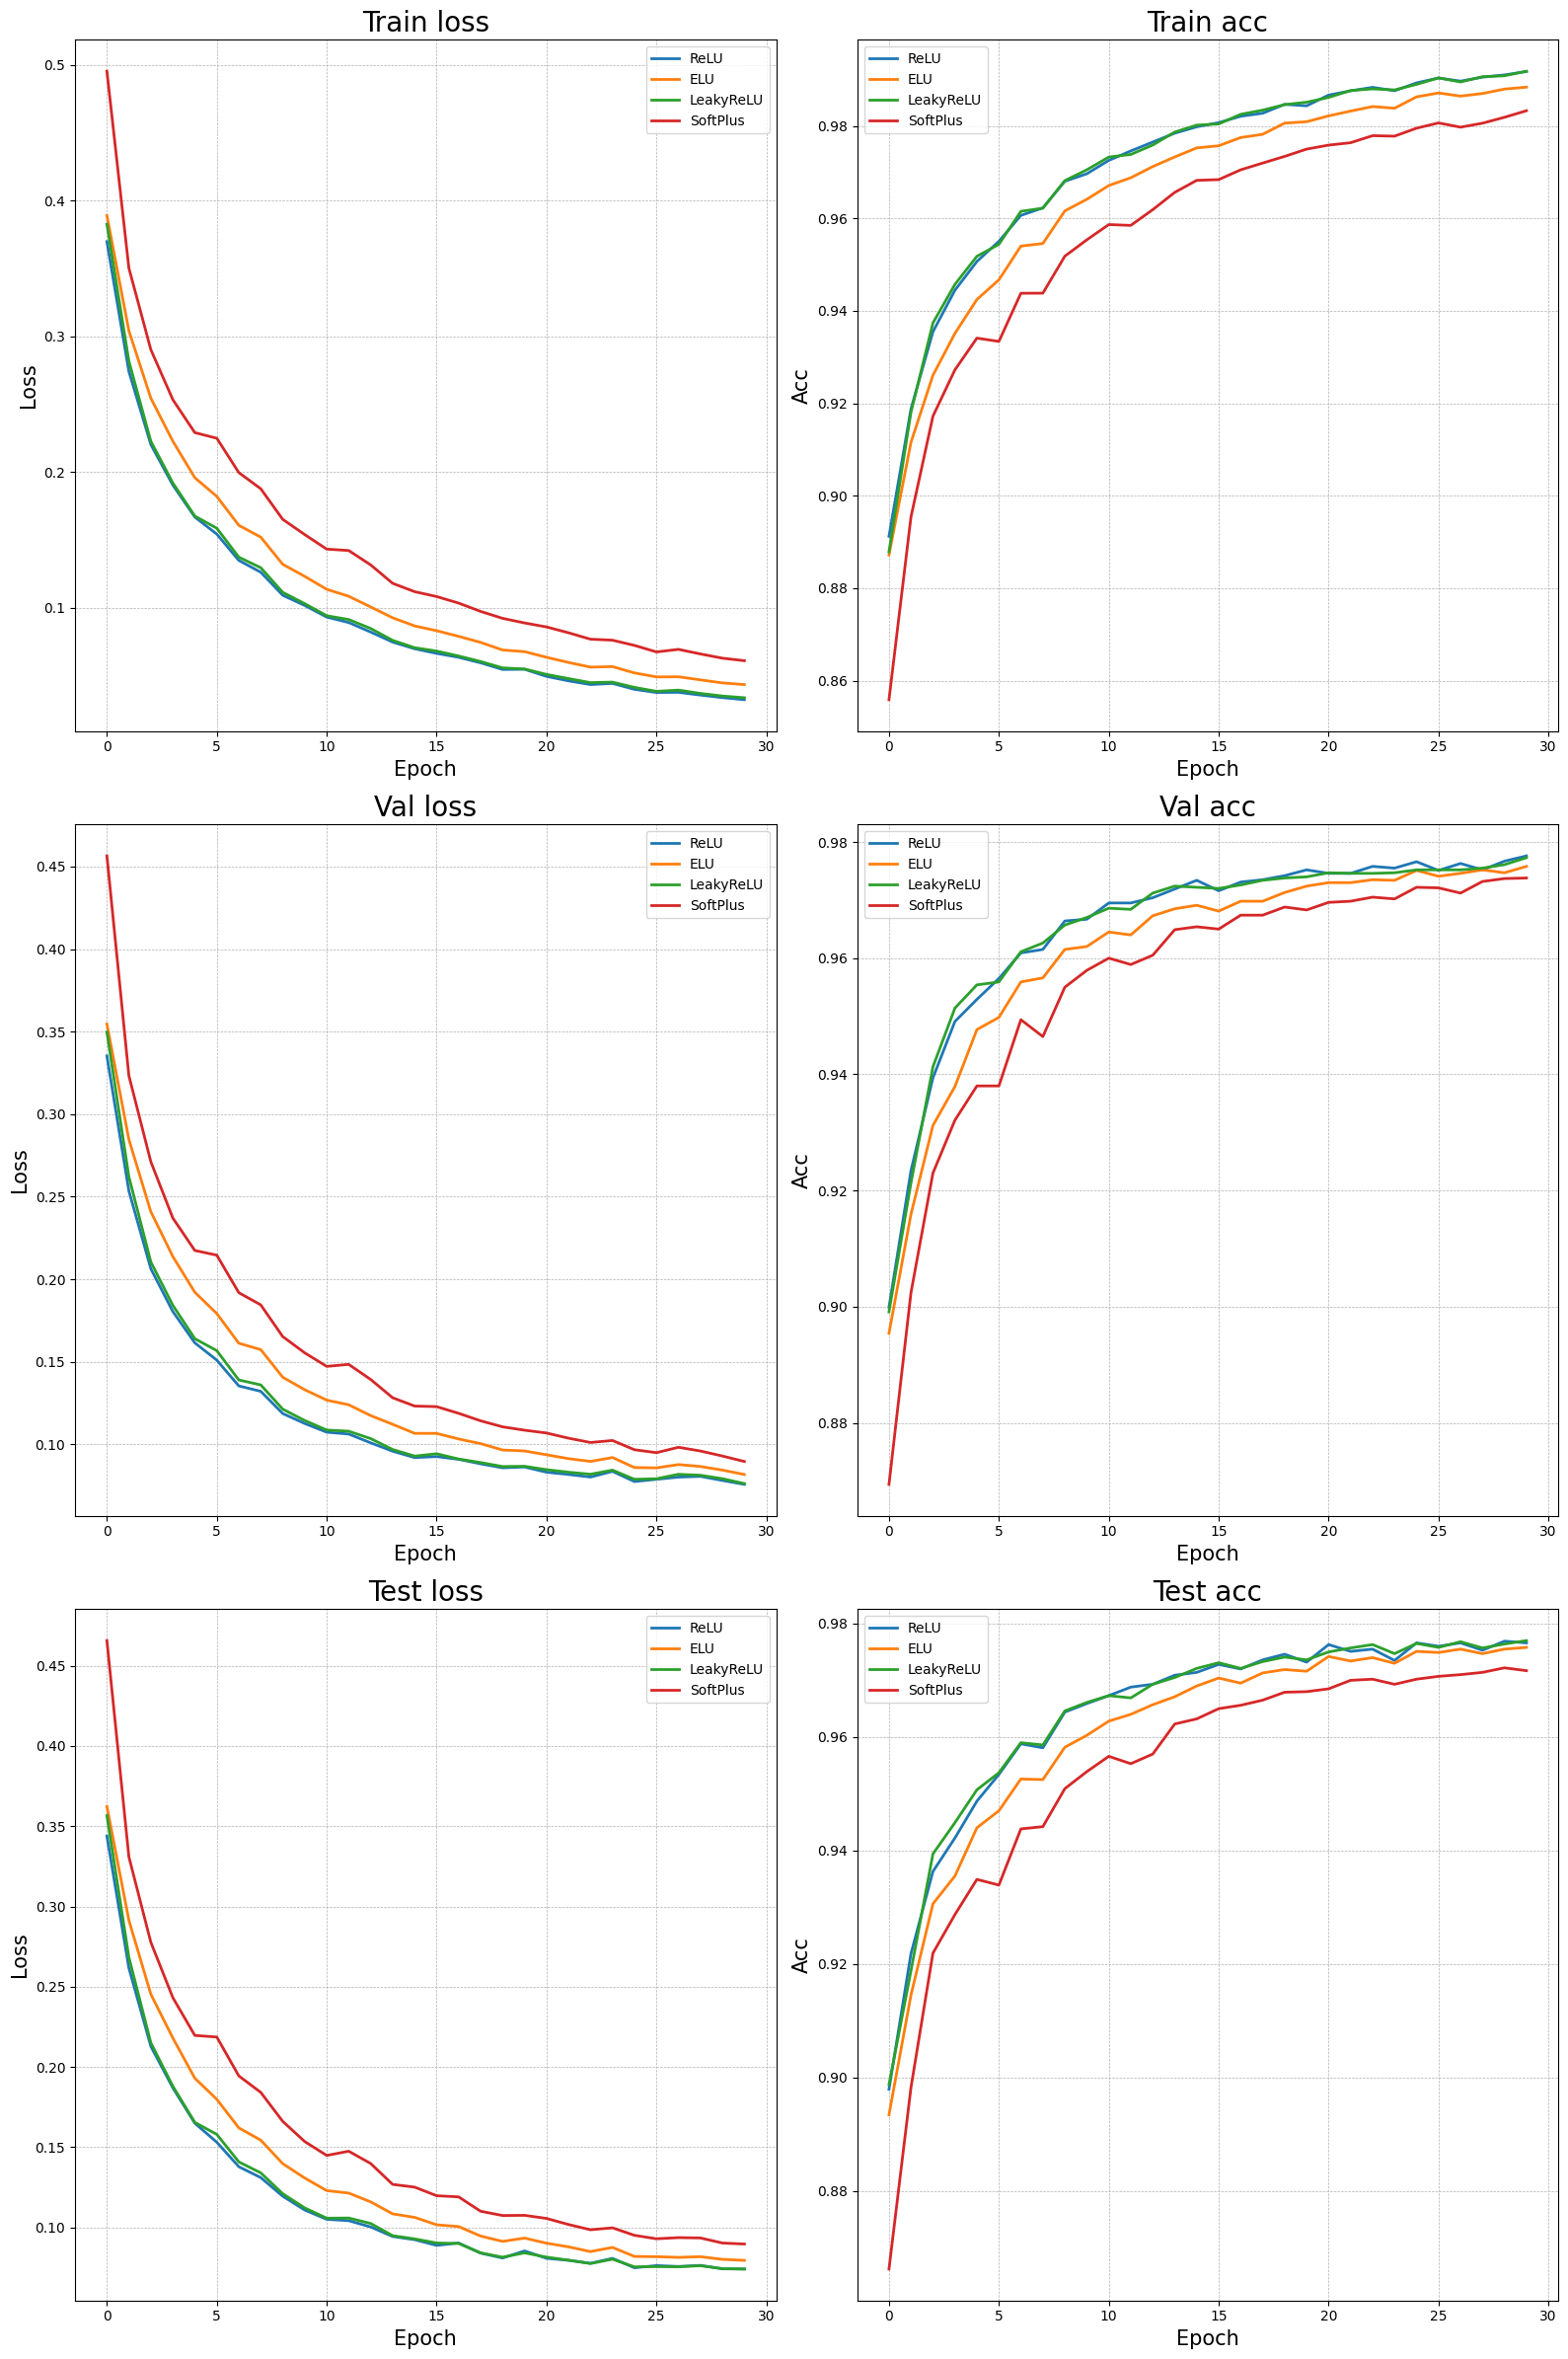

Epoch 30/30
ReLU training time: 90.39s
ELU training time: 98.38s
LeakyReLU training time: 95.40s
SoftPlus training time: 95.20s


In [20]:
# Создание сетей
def create_networks():
    networks = {}

    net_relu = Sequential()
    net_relu.add(Linear(28 * 28, 200))
    net_relu.add(ReLU())
    net_relu.add(Linear(200, 10))
    net_relu.add(LogSoftMax())
    networks["ReLU"] = (net_relu, ClassNLLCriterion())

    net_elu = Sequential()
    net_elu.add(Linear(28 * 28, 200))
    net_elu.add(ELU())
    net_elu.add(Linear(200, 10))
    net_elu.add(LogSoftMax())
    networks["ELU"] = (net_elu, ClassNLLCriterion())

    net_leakrelu = Sequential()
    net_leakrelu.add(Linear(28 * 28, 200))
    net_leakrelu.add(LeakyReLU())
    net_leakrelu.add(Linear(200, 10))
    net_leakrelu.add(LogSoftMax())
    networks["LeakyReLU"] = (net_leakrelu, ClassNLLCriterion())

    net_soft = Sequential()
    net_soft.add(Linear(28 * 28, 200))
    net_soft.add(SoftPlus())
    net_soft.add(Linear(200, 10))
    net_soft.add(LogSoftMax())
    networks["SoftPlus"] = (net_soft, ClassNLLCriterion())

    return networks


# Инициализация параметров
n_epoch = 30
batch_size = 1000
optimizer_config = {"learning_rate": 1e-1, "momentum": 0.9}
optimizer_state = {}
metrics = {k: {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "test_loss": [], "test_acc": []} for k in ["ReLU", "ELU", "LeakyReLU", "SoftPlus"]}
training_times = {key: 0 for key in metrics.keys()}

# Получение сетей
networks = create_networks()

# Тренировка сетей
for epoch in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, one_hot_y_train), batch_size):
        for name, (network, criterion) in networks.items():
            network.zeroGradParameters()
            start_time = time()
            predictions = network.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            dp = criterion.backward(predictions, y_batch)
            network.backward(x_batch, dp)
            sgd_momentum(network.getParameters(), network.getGradParameters(), optimizer_config, optimizer_state)
            training_times[name] += time() - start_time

    # Сохранение метрик
    for name, (network, criterion) in networks.items():
        pred_train = network.forward(X_train)
        metrics[name]["train_loss"].append(criterion.forward(pred_train, one_hot_y_train))
        metrics[name]["train_acc"].append(accuracy(pred_train, np.argmax(one_hot_y_train, axis=-1)))

        pred_val = network.forward(X_val)
        metrics[name]["val_loss"].append(criterion.forward(pred_val, one_hot_y_val))
        metrics[name]["val_acc"].append(accuracy(pred_val, np.argmax(one_hot_y_val, axis=-1)))

        pred_test = network.forward(X_test)
        metrics[name]["test_loss"].append(criterion.forward(pred_test, one_hot_y_test))
        metrics[name]["test_acc"].append(accuracy(pred_test, np.argmax(one_hot_y_test, axis=-1)))

    # Визуализация на каждом шаге
    display.clear_output(wait=True)
    plt.figure(figsize=(16, 24))
    for i, metric in enumerate(["train_loss", "train_acc", "val_loss", "val_acc", "test_loss", "test_acc"]):
        plt.subplot(3, 2, i + 1)
        for name in metrics.keys():
            plt.plot(metrics[name][metric], label=name, lw=2)
        plt.title(metric.replace("_", " ").capitalize(), fontsize=20)
        plt.xlabel("Epoch", fontsize=15)
        plt.ylabel(metric.split("_")[1].capitalize(), fontsize=15)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Epoch {epoch + 1}/{n_epoch}")
    for name in training_times:
        print(f"{name} training time: {training_times[name]:.2f}s")



Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

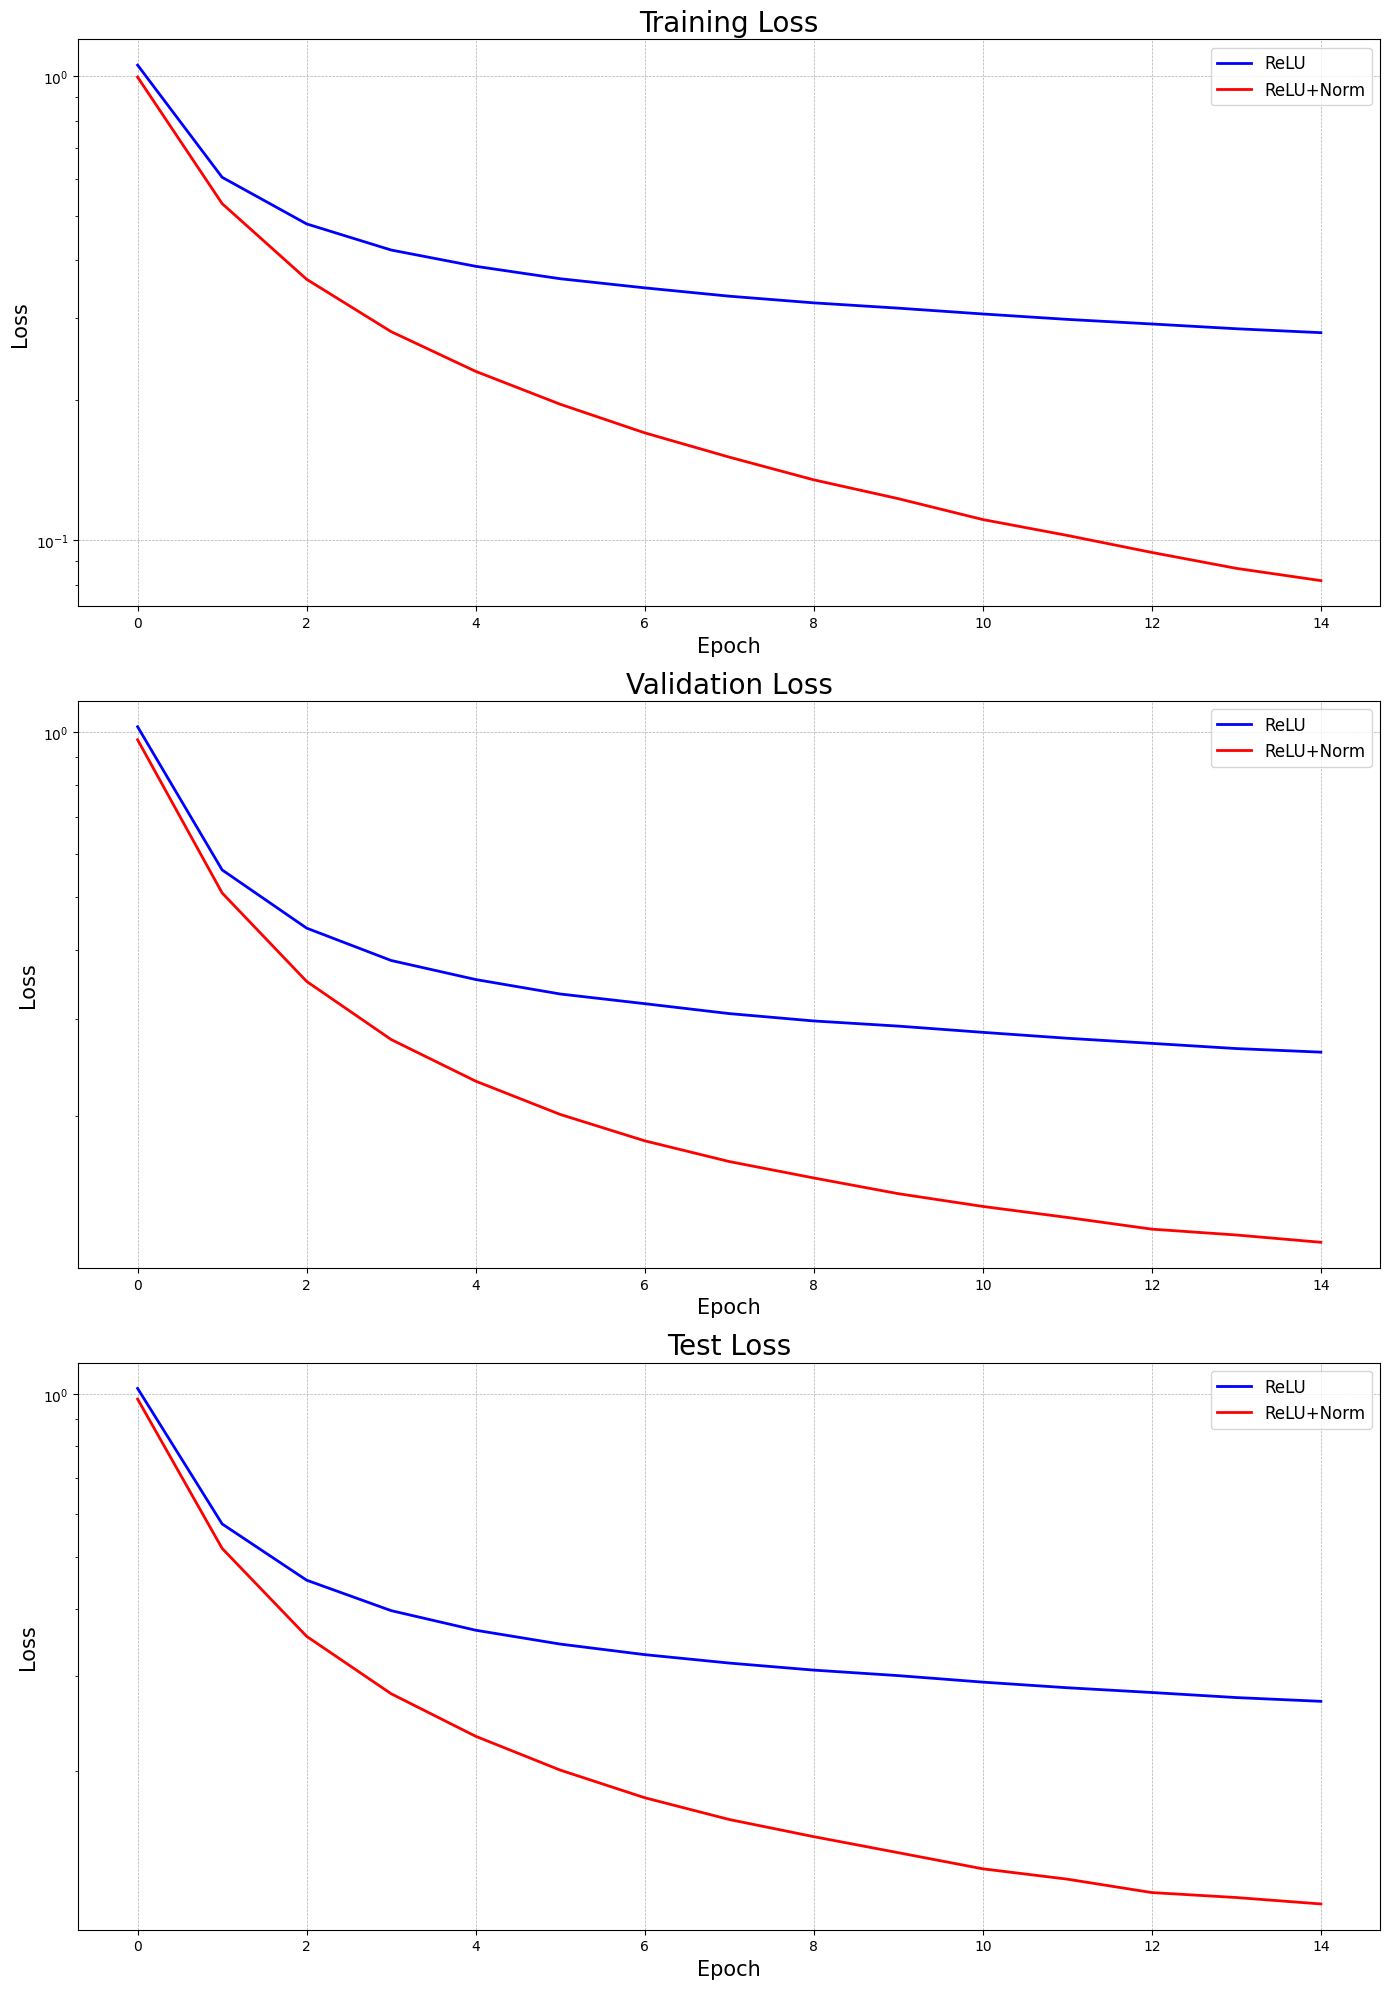

Epoch 15/15
ReLU training time: 37.83 s
ReLU+Norm training time: 39.01 s
Final training times:
ReLU: 37.8257 s
ReLU+Norm: 39.0087 s


In [21]:
# Создание сетей
def create_networks():
    net_relu = Sequential()
    net_relu.add(Linear(28 * 28, 100))
    net_relu.add(ReLU())
    net_relu.add(Linear(100, 10))
    net_relu.add(LogSoftMax())
    criterion_relu = ClassNLLCriterion()

    net_norm = Sequential()
    net_norm.add(Linear(28 * 28, 100))
    net_norm.add(BatchNormalization())
    net_norm.add(ChannelwiseScaling(100))
    net_norm.add(ReLU())
    net_norm.add(Linear(100, 10))
    net_norm.add(BatchNormalization())
    net_norm.add(ChannelwiseScaling(10))
    net_norm.add(LogSoftMax())
    criterion_norm = ClassNLLCriterion()

    return {"ReLU": (net_relu, criterion_relu), "ReLU+Norm": (net_norm, criterion_norm)}


# Инициализация
n_epoch = 15
batch_size = 1000
optimizer_config = {"learning_rate": 1e-1, "momentum": 0.9}
networks = create_networks()

# Метрики
metrics = {
    "ReLU": {"train_loss": [], "val_loss": [], "test_loss": []},
    "ReLU+Norm": {"train_loss": [], "val_loss": [], "test_loss": []},
}
training_times = {"ReLU": 0, "ReLU+Norm": 0}

# Тренировка
for epoch in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, one_hot_y_train), batch_size):
        for name, (net, criterion) in networks.items():
            net.zeroGradParameters()
            start_time = time()
            preds = net.forward(x_batch)
            loss = criterion.forward(preds, y_batch)
            dp = criterion.backward(preds, y_batch)
            net.backward(x_batch, dp)
            sgd_momentum(net.getParameters(), net.getGradParameters(), optimizer_config, {})
            training_times[name] += time() - start_time

    # Сохранение метрик
    for name, (net, criterion) in networks.items():
        pred_train = net.forward(X_train)
        metrics[name]["train_loss"].append(criterion.forward(pred_train, one_hot_y_train))
        pred_val = net.forward(X_val)
        metrics[name]["val_loss"].append(criterion.forward(pred_val, one_hot_y_val))
        pred_test = net.forward(X_test)
        metrics[name]["test_loss"].append(criterion.forward(pred_test, one_hot_y_test))

    # Визуализация в процессе
    display.clear_output(wait=True)
    plt.figure(figsize=(14, 20))
    for i, (metric, title) in enumerate(
        [("train_loss", "Training Loss"), ("val_loss", "Validation Loss"), ("test_loss", "Test Loss")]
    ):
        plt.subplot(3, 1, i + 1)
        for name, color in [("ReLU", "b"), ("ReLU+Norm", "r")]:
            plt.semilogy(metrics[name][metric], lw=2, color=color, label=name)
        plt.title(title, fontsize=20)
        plt.xlabel("Epoch", fontsize=15)
        plt.ylabel("Loss", fontsize=15)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Прогресс
    print(f"Epoch {epoch + 1}/{n_epoch}")
    for name in training_times:
        print(f"{name} training time: {training_times[name]:.2f} s")

# Итоговые времена
print("Final training times:")
for name, time_taken in training_times.items():
    print(f"{name}: {round(time_taken, 4)} s")


**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

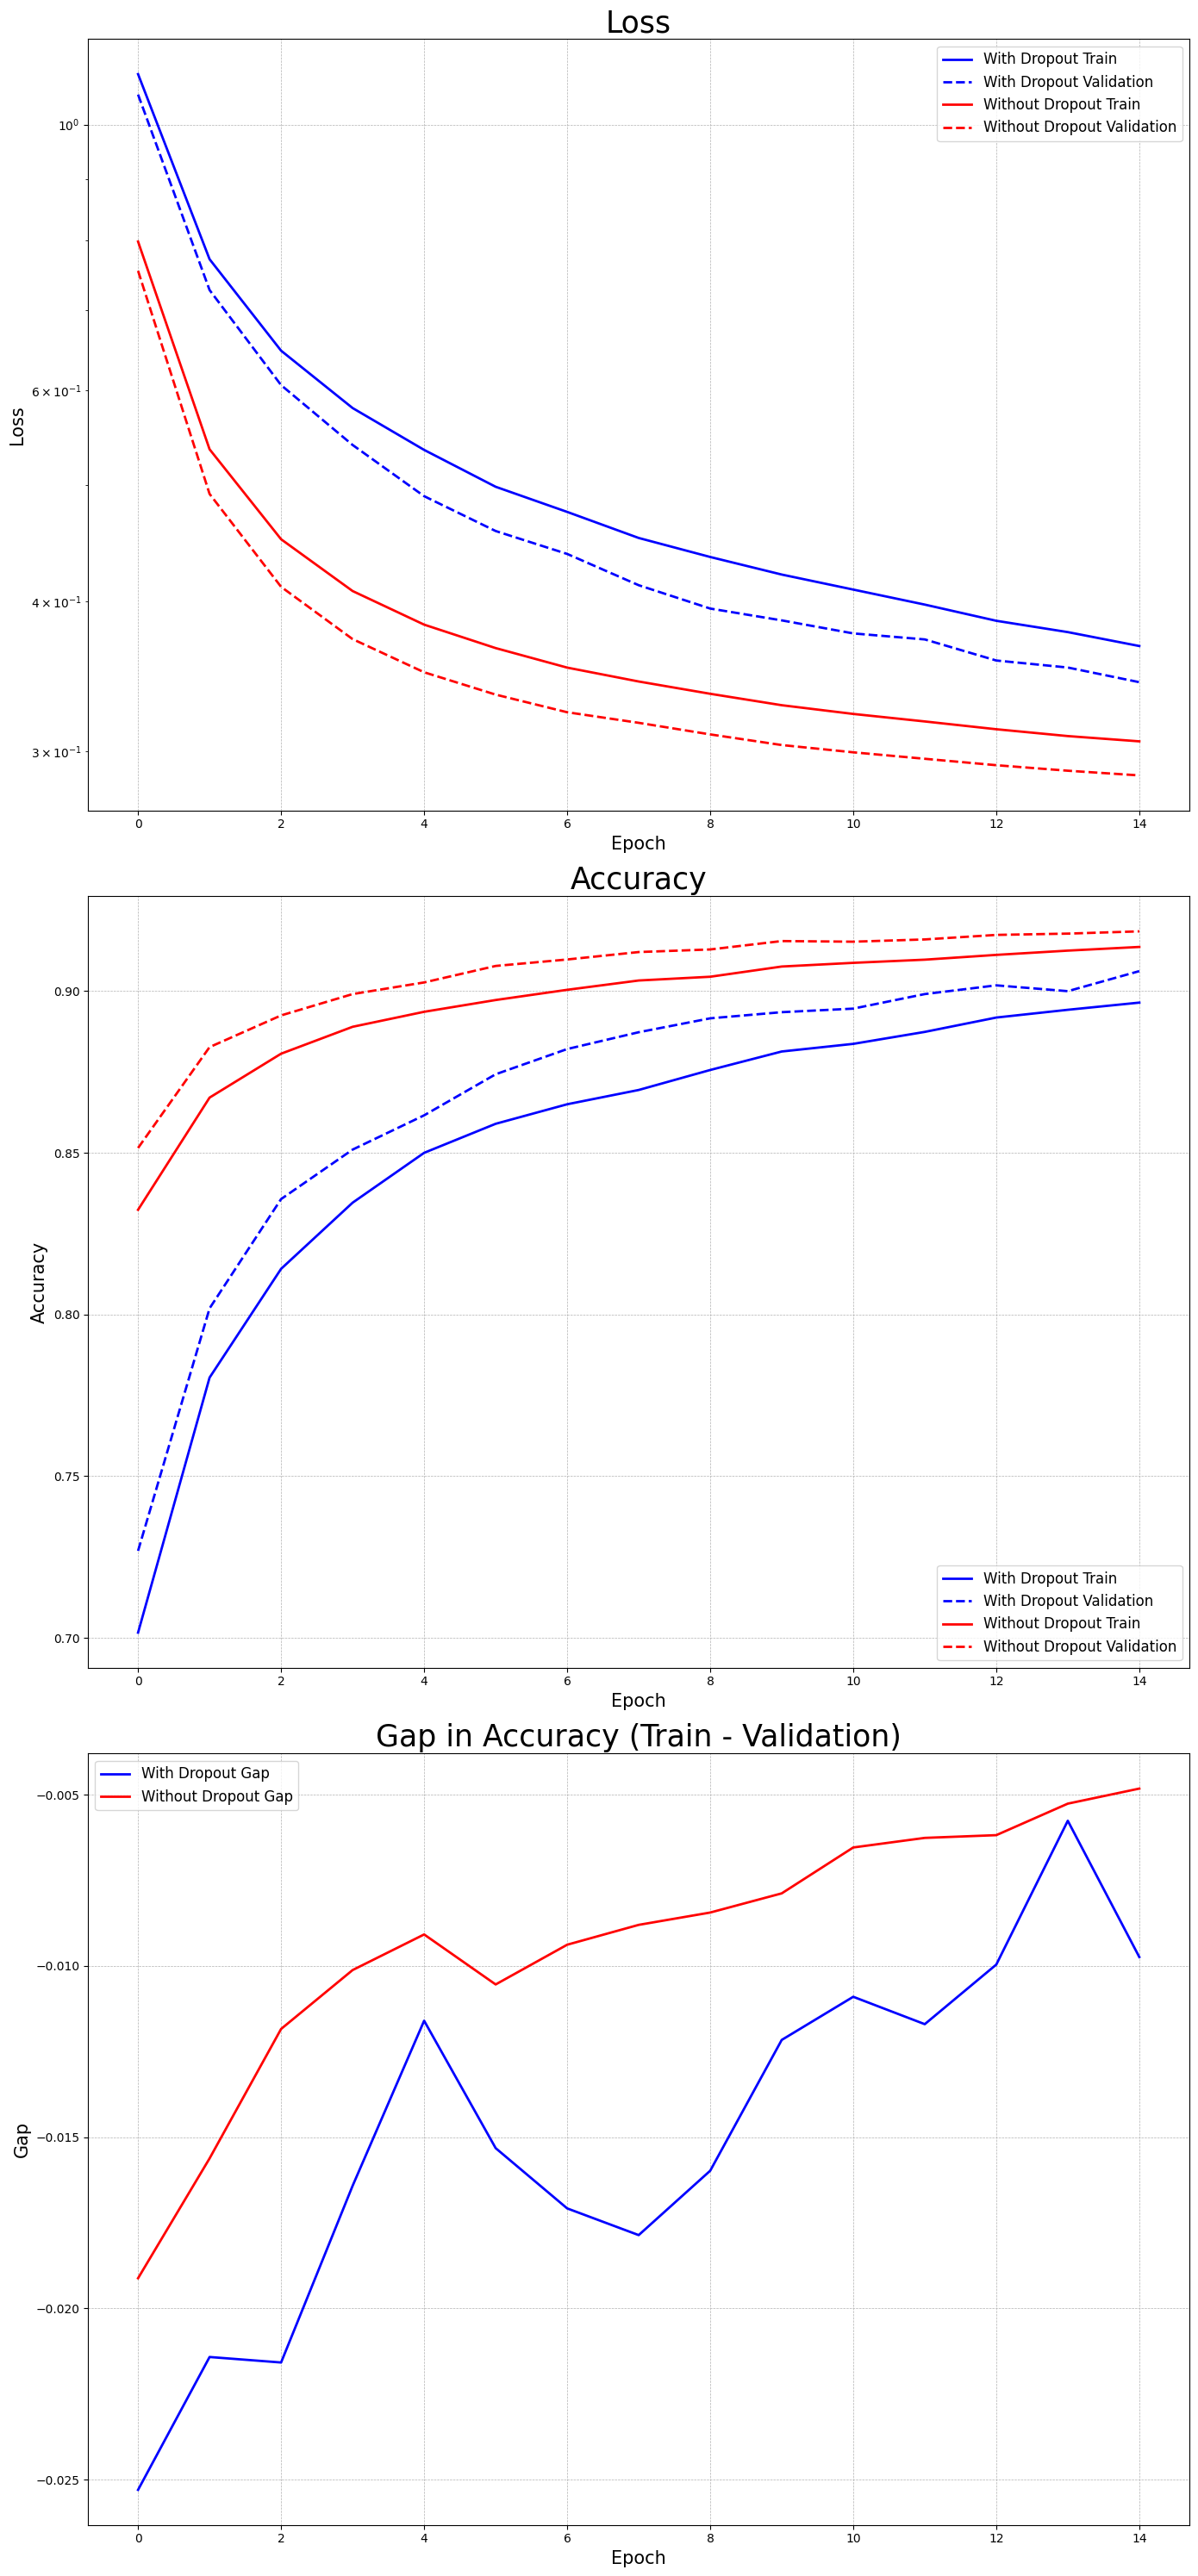

Epoch 15/15
Final Metrics:
With Dropout:
  Final Train Loss: 0.3672
  Final Validation Loss: 0.3425
  Final Train Accuracy: 0.8965
  Final Validation Accuracy: 0.9062
Without Dropout:
  Final Train Loss: 0.3057
  Final Validation Loss: 0.2864
  Final Train Accuracy: 0.9137
  Final Validation Accuracy: 0.9185


In [22]:
# Создание сетей
def create_networks():
    net_with_dropout = Sequential()
    net_with_dropout.add(Linear(28 * 28, 600))
    net_with_dropout.add(Dropout(0.9))
    net_with_dropout.add(ELU())
    net_with_dropout.add(Linear(600, 10))
    net_with_dropout.add(LogSoftMax())
    criterion_with_dropout = ClassNLLCriterion()

    net_without_dropout = Sequential()
    net_without_dropout.add(Linear(28 * 28, 600))
    net_without_dropout.add(ELU())
    net_without_dropout.add(Linear(600, 10))
    net_without_dropout.add(LogSoftMax())
    criterion_without_dropout = ClassNLLCriterion()

    return {
        "With Dropout": (net_with_dropout, criterion_with_dropout),
        "Without Dropout": (net_without_dropout, criterion_without_dropout),
    }


# Инициализация
n_epoch = 15
batch_size = 1000
optimizer_config = {"learning_rate": 1e-1, "momentum": 0.9}
networks = create_networks()

# Метрики
metrics = {
    "With Dropout": {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []},
    "Without Dropout": {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []},
}

# Тренировка
for epoch in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, one_hot_y_train), batch_size):
        for name, (net, criterion) in networks.items():
            net.zeroGradParameters()
            preds = net.forward(x_batch)
            loss = criterion.forward(preds, y_batch)
            dp = criterion.backward(preds, y_batch)
            net.backward(x_batch, dp)
            sgd_momentum(net.getParameters(), net.getGradParameters(), optimizer_config, {})

    # Сохранение метрик
    for name, (net, criterion) in networks.items():
        pred_train = net.forward(X_train)
        metrics[name]["train_loss"].append(criterion.forward(pred_train, one_hot_y_train))
        metrics[name]["train_acc"].append(accuracy(pred_train, np.argmax(one_hot_y_train, axis=-1)))

        pred_val = net.forward(X_val)
        metrics[name]["val_loss"].append(criterion.forward(pred_val, one_hot_y_val))
        metrics[name]["val_acc"].append(accuracy(pred_val, np.argmax(one_hot_y_val, axis=-1)))

    # Обновление графиков
    display.clear_output(wait=True)
    plt.figure(figsize=(14, 30))

    # График 1: Loss
    plt.subplot(3, 1, 1)
    for name, color in [("With Dropout", "b"), ("Without Dropout", "r")]:
        plt.semilogy(metrics[name]["train_loss"], lw=2, label=f"{name} Train", color=color)
        plt.semilogy(metrics[name]["val_loss"], lw=2, label=f"{name} Validation", linestyle="--", color=color)
    plt.title("Loss", fontsize=25)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(fontsize=12)

    # График 2: Accuracy
    plt.subplot(3, 1, 2)
    for name, color in [("With Dropout", "b"), ("Without Dropout", "r")]:
        plt.plot(metrics[name]["train_acc"], lw=2, label=f"{name} Train", color=color)
        plt.plot(metrics[name]["val_acc"], lw=2, label=f"{name} Validation", linestyle="--", color=color)
    plt.title("Accuracy", fontsize=25)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Accuracy", fontsize=15)
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(fontsize=12)

    # График 3: Gap in Accuracy
    plt.subplot(3, 1, 3)
    for name, color in [("With Dropout", "b"), ("Without Dropout", "r")]:
        gap = np.array(metrics[name]["train_acc"]) - np.array(metrics[name]["val_acc"])
        plt.plot(gap, lw=2, label=f"{name} Gap", color=color)
    plt.title("Gap in Accuracy (Train - Validation)", fontsize=25)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Gap", fontsize=15)
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

    # Вывод текущей информации
    print(f"Epoch {epoch + 1}/{n_epoch}")

# Итоговая информация
print("Final Metrics:")
for name in metrics:
    print(f"{name}:")
    print(f"  Final Train Loss: {metrics[name]['train_loss'][-1]:.4f}")
    print(f"  Final Validation Loss: {metrics[name]['val_loss'][-1]:.4f}")
    print(f"  Final Train Accuracy: {metrics[name]['train_acc'][-1]:.4f}")
    print(f"  Final Validation Accuracy: {metrics[name]['val_acc'][-1]:.4f}")


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

Training With Dropout model...
Epoch 1/10 - Train Loss: 0.0010, Val Loss: 0.0004, Train Acc: 0.6990, Val Acc: 0.8893
Epoch 2/10 - Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 0.8670, Val Acc: 0.9019
Epoch 3/10 - Train Loss: 0.0004, Val Loss: 0.0004, Train Acc: 0.8898, Val Acc: 0.9034
Epoch 4/10 - Train Loss: 0.0003, Val Loss: 0.0004, Train Acc: 0.8985, Val Acc: 0.9031
Epoch 5/10 - Train Loss: 0.0003, Val Loss: 0.0004, Train Acc: 0.9072, Val Acc: 0.9058
Epoch 6/10 - Train Loss: 0.0003, Val Loss: 0.0005, Train Acc: 0.9110, Val Acc: 0.8972
Epoch 7/10 - Train Loss: 0.0003, Val Loss: 0.0005, Train Acc: 0.9157, Val Acc: 0.8908
Epoch 8/10 - Train Loss: 0.0003, Val Loss: 0.0005, Train Acc: 0.9195, Val Acc: 0.8888
Epoch 9/10 - Train Loss: 0.0003, Val Loss: 0.0005, Train Acc: 0.9235, Val Acc: 0.8869
Epoch 10/10 - Train Loss: 0.0003, Val Loss: 0.0005, Train Acc: 0.9241, Val Acc: 0.8830
Training Without Dropout model...
Epoch 1/10 - Train Loss: 0.0007, Val Loss: 0.0003, Train Acc: 0.8120, Val 

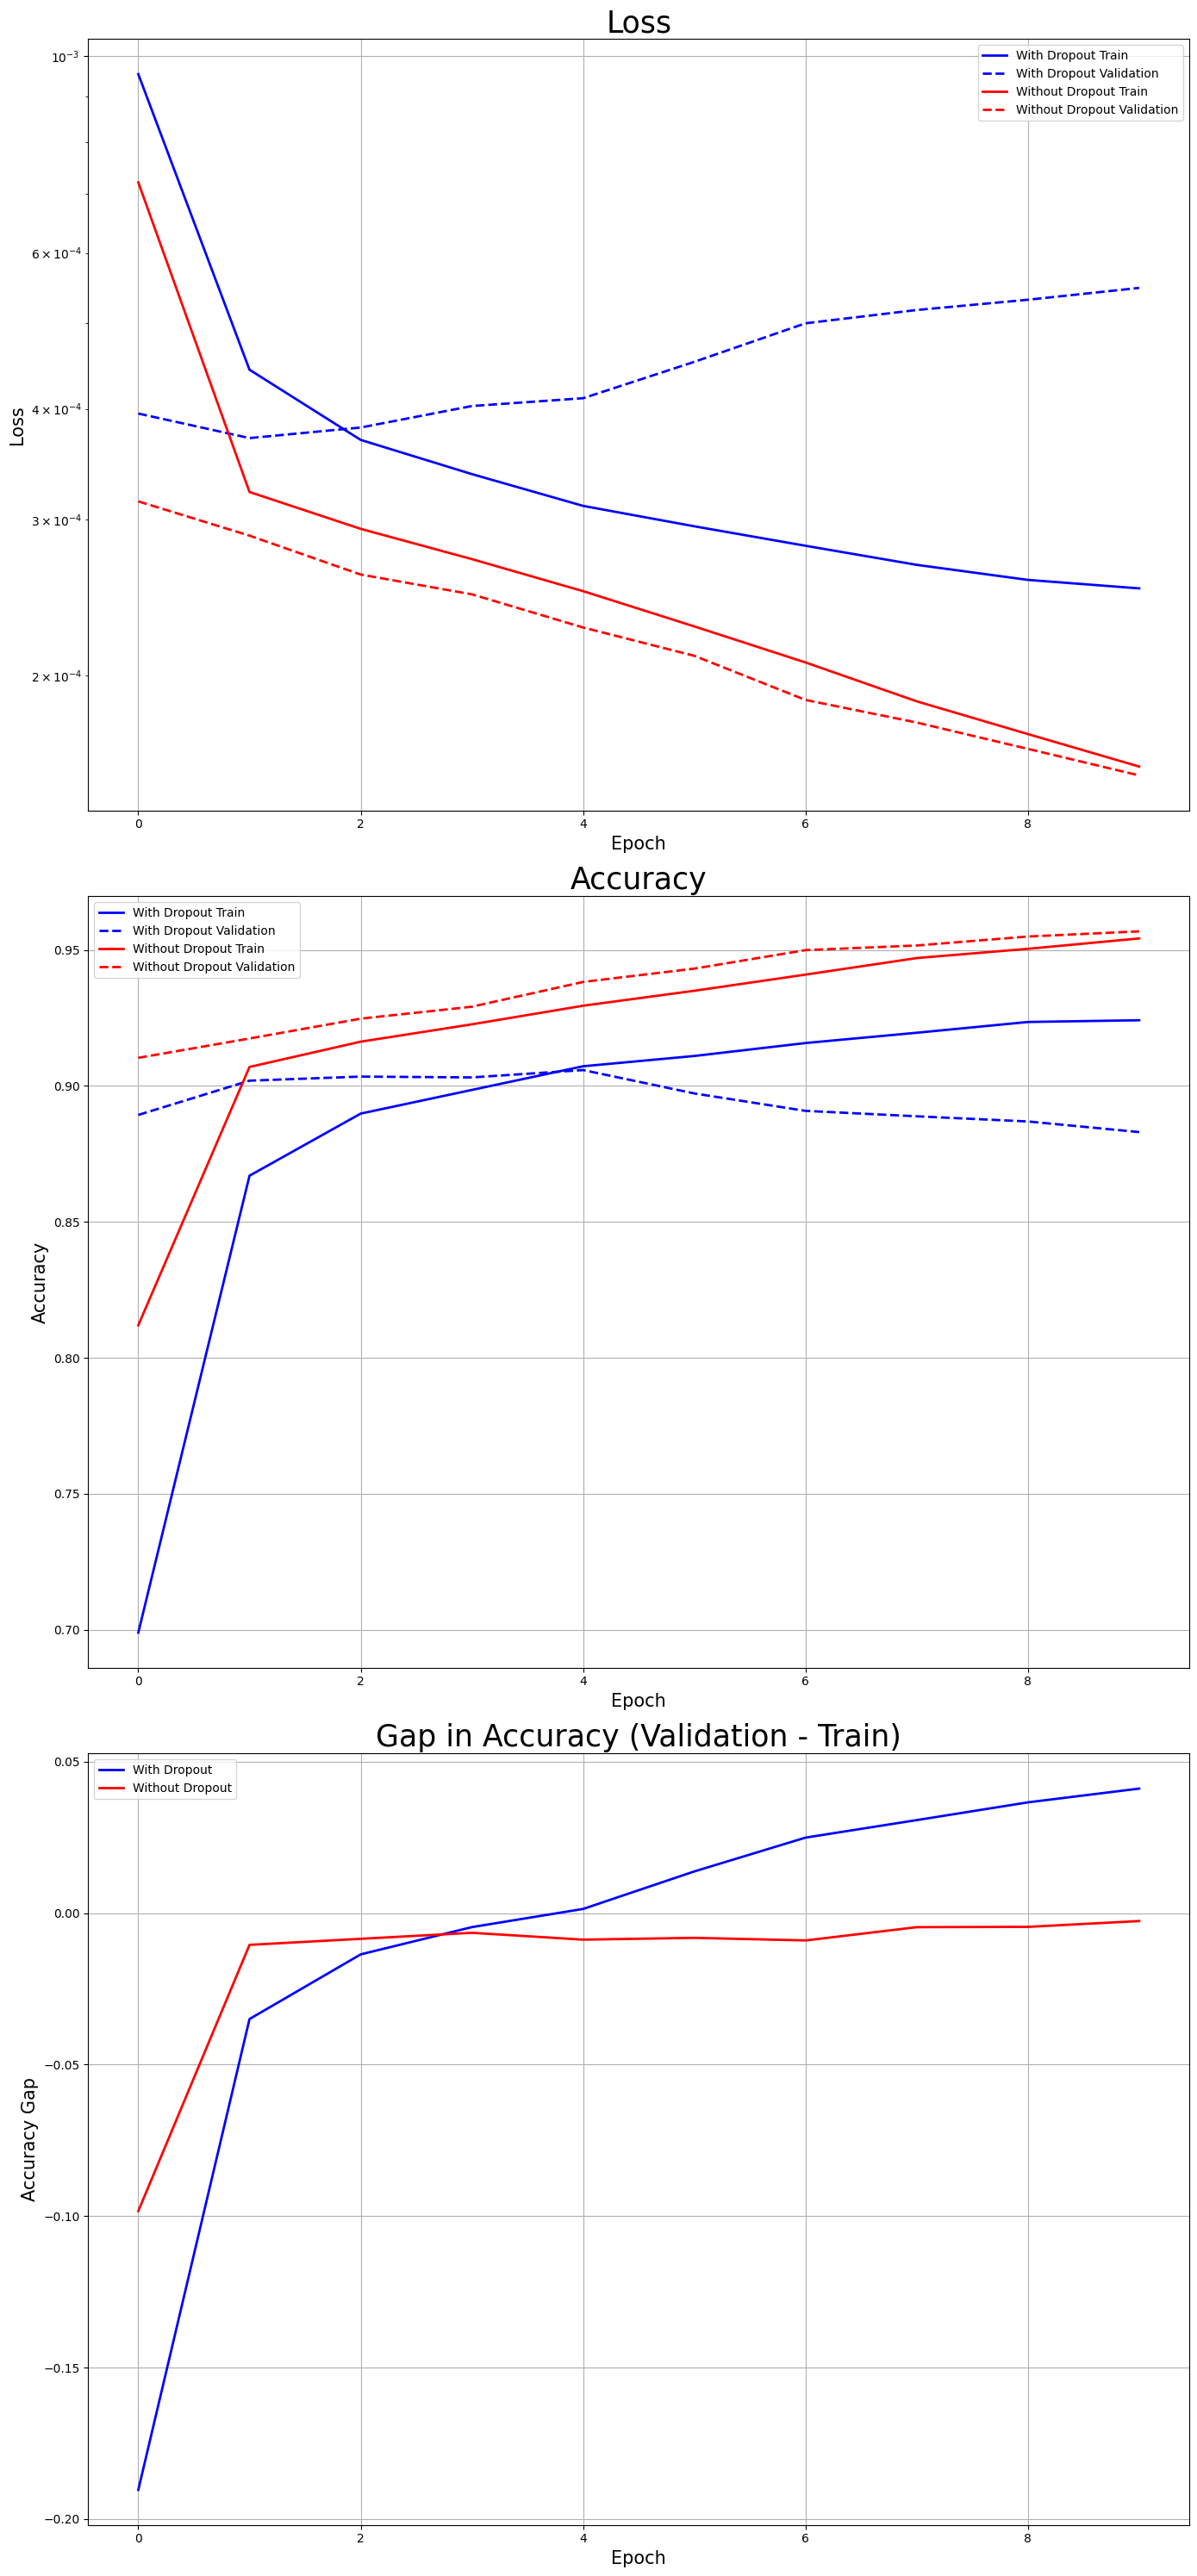

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Определение моделей
class NeuralNet(nn.Module):
    def __init__(self, use_dropout=False):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 600)
        self.elu = nn.ELU()
        self.dropout = nn.Dropout(0.9) if use_dropout else nn.Identity()
        self.fc2 = nn.Linear(600, 10)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.elu(x)
        x = self.fc2(x)
        x = self.log_softmax(x)
        return x

# Функция обучения
def train_model(model, optimizer, criterion, train_loader, val_loader, n_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(n_epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == y_batch).sum().item()

        train_losses.append(train_loss / len(train_loader.dataset))
        train_accuracies.append(train_correct / len(train_loader.dataset))

        # Валидация
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == y_val).sum().item()

        val_losses.append(val_loss / len(val_loader.dataset))
        val_accuracies.append(val_correct / len(val_loader.dataset))

        print(f"Epoch {epoch + 1}/{n_epochs} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
              f"Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

# Датасеты и DataLoader
def prepare_dataloaders(X_train, y_train, X_val, y_val, batch_size=1000):
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# Обучение и визуализация
def run_experiment(X_train, y_train, X_val, y_val, n_epochs=10):
    train_loader, val_loader = prepare_dataloaders(X_train, y_train, X_val, y_val)

    models = {
        "With Dropout": NeuralNet(use_dropout=True),
        "Without Dropout": NeuralNet(use_dropout=False),
    }
    results = {}

    for name, model in models.items():
        optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        criterion = nn.NLLLoss()
        print(f"Training {name} model...")
        train_losses, train_accuracies, val_losses, val_accuracies = train_model(
            model, optimizer, criterion, train_loader, val_loader, n_epochs
        )
        results[name] = (train_losses, train_accuracies, val_losses, val_accuracies)

    # Визуализация
    plt.figure(figsize=(14, 30))

    # Loss
    plt.subplot(3, 1, 1)
    plt.title("Loss", fontsize=25)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    for name, color in [("With Dropout", "b"), ("Without Dropout", "r")]:
        train_losses, _, val_losses, _ = results[name]
        plt.semilogy(train_losses, lw=2, label=f"{name} Train", color=color)
        plt.semilogy(val_losses, lw=2, label=f"{name} Validation", linestyle="--", color=color)
    plt.grid(True)
    plt.legend()

    # Accuracy
    plt.subplot(3, 1, 2)
    plt.title("Accuracy", fontsize=25)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Accuracy", fontsize=15)
    for name, color in [("With Dropout", "b"), ("Without Dropout", "r")]:
        _, train_accuracies, _, val_accuracies = results[name]
        plt.plot(train_accuracies, lw=2, label=f"{name} Train", color=color)
        plt.plot(val_accuracies, lw=2, label=f"{name} Validation", linestyle="--", color=color)
    plt.grid(True)
    plt.legend()

    # Gap in Accuracy
    plt.subplot(3, 1, 3)
    plt.title("Gap in Accuracy (Validation - Train)", fontsize=25)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Accuracy Gap", fontsize=15)
    for name, color in [("With Dropout", "b"), ("Without Dropout", "r")]:
        _, train_accuracies, _, val_accuracies = results[name]
        gap = np.array(train_accuracies) - np.array(val_accuracies)
        plt.plot(gap, lw=2, label=name, color=color)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Запуск эксперимента
run_experiment(X_train, y_train, X_val, y_val, n_epochs=10)
